# Data visualization

In [5]:
import os
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

TODO: fix the right_claw data, because it got out of hand somewhere a bit

## Bad data
- Visualize patterns, identify possible errors (logical or numerical)

In [2]:
!rm -r 2025-tidy-python
!git clone https://github.com/Py-ualg/2025-tidy-python.git

rm: cannot remove '2025-tidy-python': No such file or directory
Cloning into '2025-tidy-python'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (653/653), done.
remote: Compressing objects: 100% (630/630), done.
remote: Total 653 (delta 66), reused 586 (delta 20), pack-reused 0 (from 0)
Receiving objects: 100% (653/653), 12.83 MiB | 20.21 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [6]:
data_tidy_path = '2025-tidy-python/r2py/tidy-data-python/'

In [7]:
df = pd.read_parquet(os.path.join(data_tidy_path, 'crabs.parquet'))

In [8]:
df.head()

,region,date,species,sex,stage,is_gravid,carapace_width,carapace_length,front_width,left_claw_length,right_claw_length,depth [m],associated_species,behaviour
0,Ria Alvor,2022-01-04,Afruca farensis,NaN,pre_puberty,False,16.179774,19.0,2.0,7.065256,1.249854,8,"['Polychaete Worm', 'Small Fish', 'Crab (Other...",Sitting still blending with environment.
1,Ria Alvor,2022-01-04,Afruca farensis,male,adult,False,17.533657,21.0,5.0,4.131649,6.824946,7,"['Barnacle', 'Sea Urchin', 'Algae', 'Shrimp', ...",Using claws to dig into sediment.
2,Ria Alvor,2022-01-04,Afruca farensis,male,juvenile,False,17.613623,27.0,4.0,3.437135,184.995377,10,"['Small Fish', 'Polychaete Worm']",Rapid crossing of open sand.
3,Ria Alvor,2022-01-04,Afruca farensis,male,juvenile,False,17.073995,28.0,2.0,6.476798,0.421570,8,"['Shrimp', 'Coral Fragment', 'Sea Urchin', 'He...",Climbing seaweed stalks.
4,Ria Alvor,2022-01-04,Uca olhanensis,NaN,sub_adult,False,17.725559,19.0,3.0,5.803654,79.730934,4,['Small Fish'],Exchanging antenna taps.


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22091 entries, 0 to 22090
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   region              22091 non-null  category      
 1   date                22091 non-null  datetime64[ns]
 2   species             22091 non-null  category      
 3   sex                 16136 non-null  category      
 4   stage               22091 non-null  category      
 5   is_gravid           22091 non-null  bool          
 6   carapace_width      22091 non-null  float64       
 7   carapace_length     22091 non-null  float64       
 8   front_width         22091 non-null  float64       
 9   left_claw_length    22091 non-null  float64       
 10  right_claw_length   22091 non-null  float64       
 11  depth [m]           22091 non-null  int64         
 12  associated_species  22091 non-null  object        
 13  behaviour           22091 non-null  object    

### Numerical columns

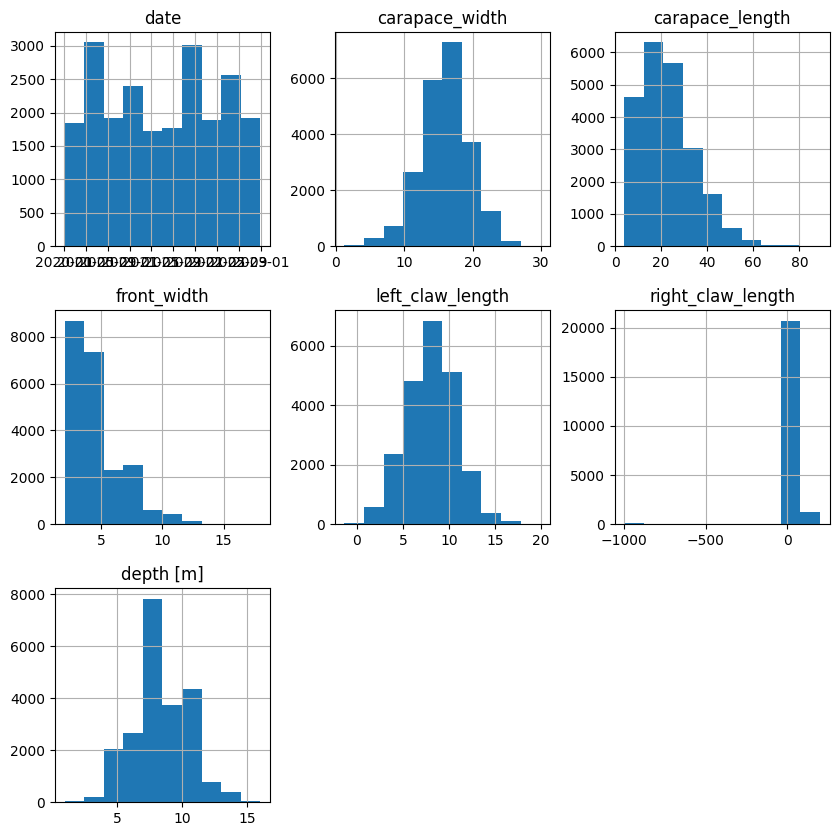

In [9]:
df.hist(figsize=(10, 10));

In [23]:
#@title Remove negative values
df1 = df[df['right_claw_length'] > 0]
df1 = df1[df1['left_claw_length'] > 0]
df1.shape, df.shape


((21966, 14), (22091, 14))

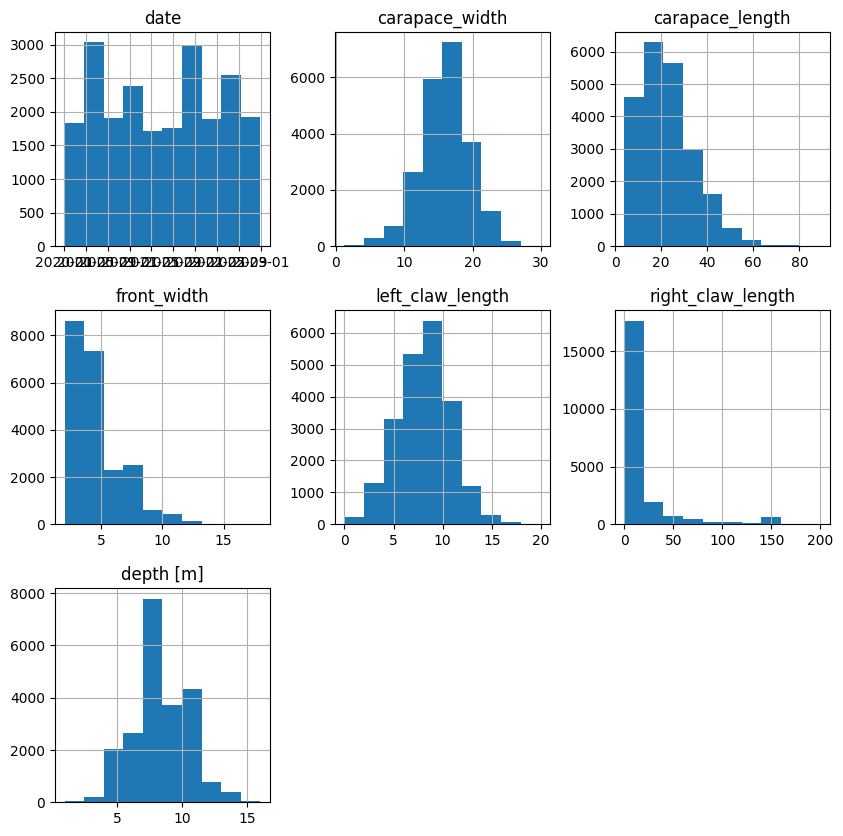

In [24]:
df1.hist(figsize=(10, 10));

In [25]:
#@title Reconcile integer vs Float values

# map columns as integers
df1 = df1.astype({
    'carapace_width': int,
    'carapace_length': int,
    'front_width': int,
    'right_claw_length': int,
    'left_claw_length': int,
})

In [26]:
df1.describe()

,date,carapace_width,carapace_length,front_width,left_claw_length,right_claw_length,depth [m]
count,21966,21966.000000,21966.000000,21966.000000,21966.000000,21966.000000,21966.000000
mean,2021-07-05 16:24:11.406719488,15.484704,22.493672,4.483247,7.627925,16.426841,8.107302
min,2020-01-05 00:00:00,1.000000,4.000000,2.000000,0.000000,0.000000,1.000000
25%,2020-09-19 00:00:00,13.000000,14.000000,3.000000,6.000000,1.000000,7.000000
50%,2021-07-15 00:00:00,16.000000,21.000000,4.000000,8.000000,4.000000,8.000000
75%,2022-04-28 00:00:00,18.000000,29.000000,6.000000,9.000000,14.000000,10.000000
max,2022-12-30 00:00:00,29.000000,89.000000,18.000000,19.000000,199.000000,16.000000
std,NaN,3.584220,11.588370,2.131521,2.719349,32.702419,2.108853


#### Extreme values

Is 199 cm for right_claw_length reasonable? What to do?
- cutoff?, drop rows? Where?
- For normal distribution, outlier can be for instance `mean +- 3STD`. This is not Normal distribution, so apply or not apply?
- Other statistical test

In [43]:
#@ Tukey's method
# Compute the interquartile range (IQR): IQR = Q3 - Q1
# Define outliers as values:
#     Below Q1 - 1.5 * IQR
#     Above Q3 + 1.5 * IQR

q1 = df1['right_claw_length'].quantile(0.25)
q3 = df1['right_claw_length'].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers = df1[(df1['right_claw_length'] < lower) | (df1['right_claw_length'] > upper)]

In [44]:
outliers

,region,date,species,sex,stage,carapace_width,carapace_length,front_width,left_claw_length,right_claw_length,depth [m],associated_species,behaviour
2,Ria Alvor,2022-01-04,Afruca farensis,male,juvenile,17,27,4,3,184,10,"['Small Fish', 'Polychaete Worm']",Rapid crossing of open sand.
4,Ria Alvor,2022-01-04,Uca olhanensis,NaN,sub_adult,17,19,3,5,79,4,['Small Fish'],Exchanging antenna taps.
5,Ria Alvor,2022-01-04,Afruca farensis,male,sub_adult,17,16,5,2,124,9,"['Snail', 'Hermit Crab', 'Algae', 'Sea Sponge'...",Emerging cautiously from hiding.
9,Ria Alvor,2022-01-04,Afruca farensis,male,pre_puberty,18,6,2,5,150,8,"['Crab (Other Species)', 'Sea Sponge', 'Small ...",Emerging cautiously from hiding.
13,Ria Alvor,2022-01-04,Afruca farensis,male,adult,18,12,3,0,37,6,"['Shrimp', 'Crab (Other Species)', 'Mussel', '...",Moving in groups.
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21886,Ria Alvor,2021-07-15,Afruca farensis,male,adult,19,9,5,8,150,7,"['Small Fish', 'Polychaete Worm', 'Sea Sponge'...",Escaping predator silhouette overhead.
21932,Ria Alvor,2021-07-15,Afruca farensis,NaN,adult,19,16,5,7,95,9,['Small Fish'],Hiding under floating debris.
21954,Ria Alvor,2021-07-15,Afruca farensis,NaN,juvenile,20,13,7,6,101,11,"['Coral Fragment', 'Barnacle', 'Hermit Crab', ...",Feeding on algae scraped from rocks.
22021,Ria Alvor,2021-07-15,Afruca farensis,male,juvenile,19,29,2,7,68,9,['Sea Urchin'],Picking algae from rock surface.


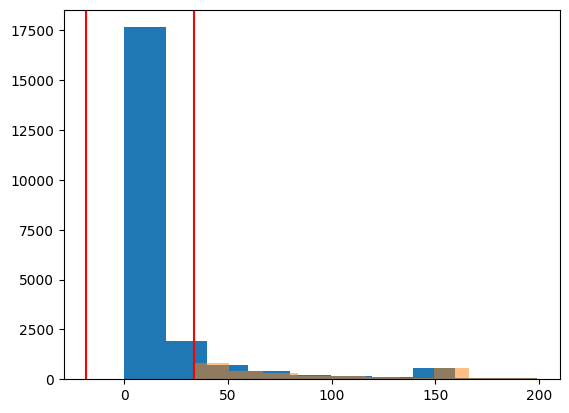

In [46]:
plt.hist(df1['right_claw_length'])
plt.axvline(x=lower, color='r')
plt.axvline(x=upper, color='r')
plt.hist(outliers['right_claw_length'], alpha=0.5)
plt.show()

### Categorical features

In [33]:
#@title What would not make sense?

df1[(df1['sex'] == 'male') & (df1['is_gravid'] == True)]

,region,date,species,sex,stage,is_gravid,carapace_width,carapace_length,front_width,left_claw_length,right_claw_length,depth [m],associated_species,behaviour
5,Ria Alvor,2022-01-04,Afruca farensis,male,sub_adult,True,17,16,5,2,124,9,"['Snail', 'Hermit Crab', 'Algae', 'Sea Sponge'...",Emerging cautiously from hiding.
14,Ria Alvor,2022-01-04,Afruca farensis,male,pre_puberty,True,17,8,4,5,6,9,['Sea Anemone'],Moving sideways along sandy bottom.
31,Ria Alvor,2022-01-04,Afruca farensis,male,sub_adult,True,16,5,8,5,150,9,"['Barnacle', 'Crab (Other Species)', 'Jellyfis...",Waving claws rhythmically.
34,Ria Alvor,2022-01-04,Afruca farensis,male,sub_adult,True,17,18,7,4,13,12,['Polychaete Worm'],Crab moving quickly across rocks.
37,Ria Alvor,2022-01-04,Uca olhanensis,male,adult,True,13,19,3,4,150,9,['Barnacle'],Color changes during molting.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22046,Ria Alvor,2021-07-15,Uca olhanensis,male,adult,True,20,16,5,8,8,7,"['Coral Fragment', 'Sea Urchin', 'Sea Star', '...",Camouflaging with surrounding mud.
22051,Ria Alvor,2021-07-15,Afruca farensis,male,juvenile,True,17,24,4,7,1,6,"['Sea Star', 'Sea Sponge', 'Crab (Other Specie...",Claw snapping in competition.
22057,Ria Alvor,2021-07-15,Afruca farensis,male,pre_puberty,True,20,13,5,8,6,6,"['Small Fish', 'Sea Sponge', 'Sea Star', 'Crab...",Retreating quickly from shadow.
22068,Ria Alvor,2021-07-15,Afruca farensis,male,pre_puberty,True,21,23,7,7,0,12,"['Hermit Crab', 'Sea Urchin', 'Snail', 'Coral ...",Defensive posture when approached.


In [34]:
df1['is_gravid'].value_counts()

,count
is_gravid,
False,17657
True,4309


1. First, pregnant males make up to 10% of all the samples,
2. Second even worse, compared to total count, it is the same amount of identified female pregnant.
3. Those are serious flaws which need domain knowledge, discussion with collaborators.

**What is the most correct thing to do for us now?**

In [38]:
df1.drop(columns=['is_gravid'], inplace=True)

### Drop NA values

In [39]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21966 entries, 0 to 22090
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   region              21966 non-null  category      
 1   date                21966 non-null  datetime64[ns]
 2   species             21966 non-null  category      
 3   sex                 16043 non-null  category      
 4   stage               21966 non-null  category      
 5   carapace_width      21966 non-null  int64         
 6   carapace_length     21966 non-null  int64         
 7   front_width         21966 non-null  int64         
 8   left_claw_length    21966 non-null  int64         
 9   right_claw_length   21966 non-null  int64         
 10  depth [m]           21966 non-null  int64         
 11  associated_species  21966 non-null  object        
 12  behaviour           21966 non-null  object        
dtypes: category(4), datetime64[ns](1), int64(6), object

In [40]:
df1['sex'].value_counts()

,count
sex,
male,10599
female,5444


In [42]:
df1['sex'].unique()

[NaN, 'male', 'female']
Categories (2, object): ['female', 'male']

This way we can keep the numerical values, even though the `sex` data is missing for 25% of samples.

## Final data
- now we cleaned and crosscheck the "clean data again"
- You can try to push these step to nb2, where it pertains, however the questions we asked here logically pertain to the greay area with no exact correct answer, so you might want it separate as here.
- Now we really are after **visualization**